# 04.图卷积网络（GCN）的原理与实现

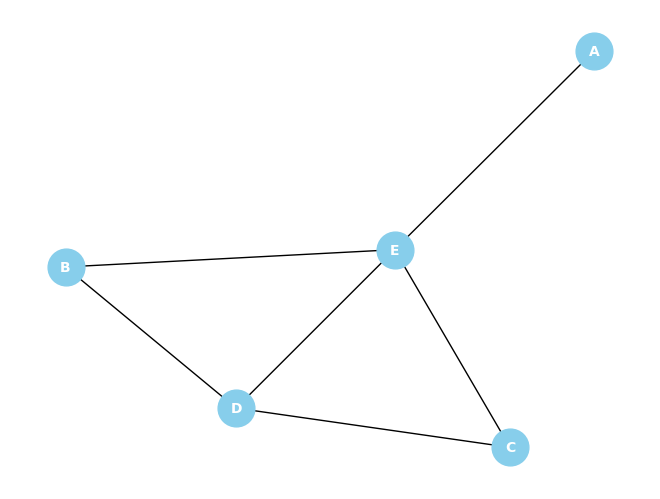

In [3]:
import networkx as nx
import matplotlib.pyplot as plt


# 创建无向图
G = nx.Graph()

# 添加节点
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)

# 添加边
edges = [('A', 'E'), ('B', 'E'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]
G.add_edges_from(edges)

# 绘制图
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='white', font_size=10)
plt.show()


In [6]:
import numpy as np

# 获取邻接矩阵
adj_matrix = nx.adjacency_matrix(G)

# 获取度矩阵
degree_matrix = np.diag(list(dict(G.degree()).values()))

print(f'邻接矩阵：\n{adj_matrix.toarray()}')
print(f'度矩阵：\n{degree_matrix}')


邻接矩阵：
[[0 0 0 0 1]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [0 1 1 0 1]
 [1 1 1 1 0]]
度矩阵：
[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 4]]


In [7]:
# 添加自环
for node in  nodes:
    G.add_edge(node, node)
    
    
# 获取邻接矩阵
adj_matrix = nx.adjacency_matrix(G)

# 获取度矩阵
degree_matrix = np.diag(list(dict(G.degree()).values()))

print(f'邻接矩阵：\n{adj_matrix.toarray()}')
print(f'度矩阵：\n{degree_matrix}')


邻接矩阵：
[[1 0 0 0 1]
 [0 1 0 1 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]
度矩阵：
[[3 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 5 0]
 [0 0 0 0 6]]


In [10]:
A_tilde = adj_matrix.toarray()
D_tilde = np.diag(np.array(list(dict(G.degree()).values())) - 1)

print(f'A_tilde：\n{A_tilde}')
print(f'D_tilde：\n{D_tilde}')



A_tilde：
[[1 0 0 0 1]
 [0 1 0 1 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]
D_tilde：
[[2 0 0 0 0]
 [0 3 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 5]]


In [11]:
# D_tilde的逆
D_tilde_inv = np.linalg.inv(D_tilde)

print(f'D_tilde的逆：\n{D_tilde_inv}')


D_tilde的逆：
[[ 0.5         0.          0.          0.          0.        ]
 [ 0.          0.33333333  0.          0.          0.        ]
 [ 0.          0.          0.33333333  0.          0.        ]
 [-0.         -0.         -0.          0.25       -0.        ]
 [ 0.          0.          0.          0.          0.2       ]]


In [12]:
# D_tilde的逆 @ A_tilde
A_tilde_hat = D_tilde_inv @ A_tilde

print(f'A_tilde的hat：\n{A_tilde_hat}')



A_tilde的hat：
[[0.5        0.         0.         0.         0.5       ]
 [0.         0.33333333 0.         0.33333333 0.33333333]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.25       0.25       0.25       0.25      ]
 [0.2        0.2        0.2        0.2        0.2       ]]


In [13]:
# D_tilde的逆 @ A_tilde @ D_tilde的逆
A_hat = D_tilde_inv @ A_tilde @ D_tilde_inv

print(f'A_hat：\n{A_hat}')

A_hat：
[[0.25       0.         0.         0.         0.1       ]
 [0.         0.11111111 0.         0.08333333 0.06666667]
 [0.         0.         0.11111111 0.08333333 0.06666667]
 [0.         0.08333333 0.08333333 0.0625     0.05      ]
 [0.1        0.06666667 0.06666667 0.05       0.04      ]]


In [14]:
# D_tilde的平方根的逆 @ A_tilde @ D_tilde的平方根的逆
D_tilde_sqrt_inv = np.linalg.inv(np.sqrt(D_tilde))
A_hat = D_tilde_sqrt_inv @ A_tilde @ D_tilde_sqrt_inv

print(f'A_hat：\n{A_hat}')


A_hat：
[[0.5        0.         0.         0.         0.31622777]
 [0.         0.33333333 0.         0.28867513 0.25819889]
 [0.         0.         0.33333333 0.28867513 0.25819889]
 [0.         0.28867513 0.28867513 0.25       0.2236068 ]
 [0.31622777 0.25819889 0.25819889 0.2236068  0.2       ]]


GCN的规范化，使得中心节点本身和邻居特征聚合的权重发生变化，是一种根据度矩阵（连接数）加权的聚合方式。对中心节点而言，邻居的度越大，传递给中心节点的信息越少。

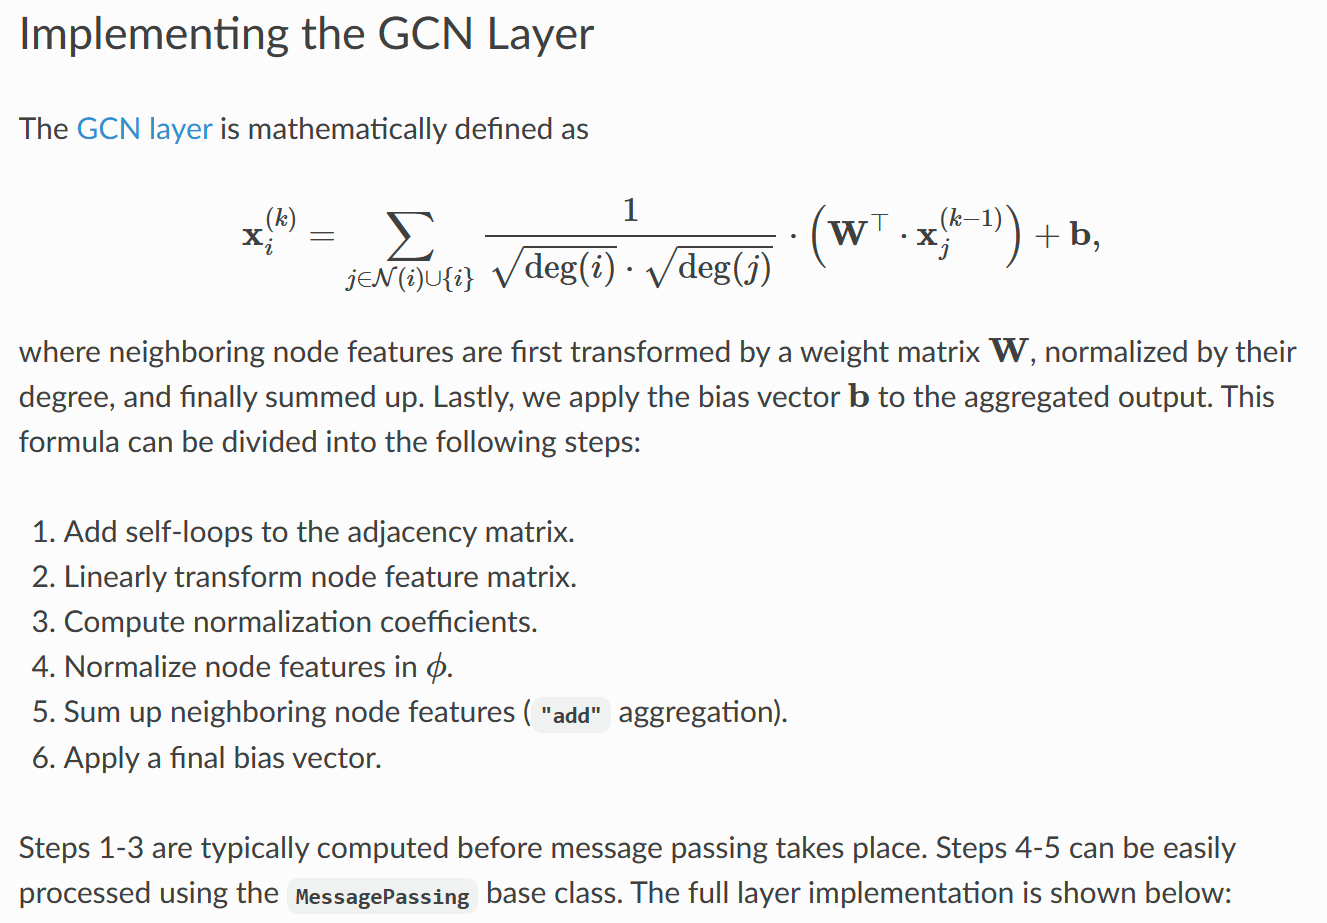

In [15]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class kk_GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(kk_GCNConv, self).__init__(aggr='add')  ## 聚合方式, step5
        self.lin = nn.Linear(in_channels, out_channels)  ## 线性变换
        self.bias = nn.Parameter(torch.empty(out_channels))  ## 偏置
        
        self.reset_parameters()  ## 初始化参数
        
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
        
        
    def forward(self, x, edge_index):
        # x 是输入的特征矩阵， shape: [num_nodes, in_channels]
        # edge_index 是边的索引， shape: [2, num_edges]
        
        # step1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # step2: Linearly transform node feature matrix.
        x = self.lin(x)
        
        # step3: Compute normalization coefficients.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # step4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)
        
        # step6: Apply a final bias.
        out += self.bias 
        
        return out
    
    def message(self, x_j, norm):
        # x_j 是邻居节点的特征矩阵， shape: [num_edges, in_channels]
        # norm 是归一化系数， shape: [num_edges]
        
        # step4: Normalize node features.
        return norm.view(-1, 1) * x_j
    